In [1]:
import pandas as pd
import numpy as np
import os
import re
from dateutil.relativedelta import relativedelta
from statsmodels.tsa import seasonal
from matplotlib import pyplot as plt
from functools import reduce  # Operação de reduce para cálculo de média de uma lista
from datetime import datetime
import math
%matplotlib inline

/Users/Tiago/Library/Python/3.6/lib/python/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Nomes das colunas adicionadas ao dataframe
COLUNA_ANOMALIA_ACUMULADA = "anomalia_acumulada"
COLUNA_ANOMALIA_DO_MES = "anomalia_mensal"
COLUNA_MEDIA_MENSAL = "media_mensal"

# Todo mês possui 25 linhas por 38 colunas que dá 950
BLOCO_DE_DADOS_DE_UM_MES = 950
QUANTIDADE_DE_VALORES_DO_ARQUIVO = 573800  # (950 blocos x 604 meses,01/1964 até 04/2014)

class LatitudeColumns:

    def __init__(self):
        self.values = range(29, -21, -2)
        self.positive = 'N'
        self.negative = 'S'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names

class LongitudeColumns:

    def __init__(self):
        #From map 60W to 15E(-17 because 'force' go to -15)
        self.values = range(59, -17, -2)
        self.positive = 'W'
        self.negative = 'E'

    def get_all_columns(self):
        colum_names = []
        for value in self.values:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(value) + self.negative
            colum_names.append(colum_name)
        return colum_names

    def get_single_column(self, desired_value, human_readable=True):
        sub_values = []
        for value in self.values:
            if value != desired_value:
                continue
            sub_values.append(value)
        if human_readable:
            return self.parse_human_readable(sub_values)
        return sub_values

    def get_range(self, init, final, human_readable=True):
        final, init = self.switch(final, init)

        sub_values = []
        if init == final:
            return self.get_single_column(init, human_readable)

        for value in self.values:
            if (value > init) or (value < final):
                continue
            sub_values.append(value)

        if human_readable:
            return self.parse_human_readable(sub_values)

        return sub_values

    def switch(self, final, init):
        if final > init:
            aux = init
            init = final
            final = aux
        return final, init

    def parse_human_readable(self, list):
        colum_names = []
        for value in list:
            if value > 0:
                colum_name = str(value) + self.positive
            else:
                colum_name = str(-value) + self.negative
            colum_names.append(colum_name)
        return colum_names


def constroi_colunas_latitude_longitude(init_lat=29, end_lat=-21,
                                        init_long=59, end_long=-17):
    lat = LatitudeColumns().get_range(init_lat, end_lat)
    long = LongitudeColumns().get_range(init_long, end_long)
    colunas_do_data_frame = []
    for linha in lat:
        for coluna in long:
            lat_long = linha + "-" + coluna
            colunas_do_data_frame.append(lat_long)
    return colunas_do_data_frame


def carrega_array_com_valores_do_arquivo_geral(
        arquivo_com_decadas_de_anomalia="funceme_db/anomalia_tsm/geral/_Dados_TSMvento_2014_04_anomt6414b04"):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO

    conteudo_do_arquivo = open(arquivo_com_decadas_de_anomalia).read()
    conteudo_do_arquivo = conteudo_do_arquivo.replace("\n", "")

    # Carrega todos os dados de anomalia em um único array
    qtd_char_no_arquivo = 5
    # Todos os valores do arquivo em um único array. Não há separação de mês. Tudo está de forma sequencial
    valores_do_arquivo = []
    for rows_index in range(QUANTIDADE_DE_VALORES_DO_ARQUIVO):
        # slice data like (n:n+5)
        value = float(conteudo_do_arquivo[
                      rows_index * qtd_char_no_arquivo: rows_index * qtd_char_no_arquivo + qtd_char_no_arquivo])
        value = float("%.3f" % value)
        value /= 10
        valores_do_arquivo.append(value)
    return valores_do_arquivo


def carrega_array_com_valores_do_arquivo_mensal(file_name):
    file_content = open(file_name).read()

    # Remove header de um único arquivo
    file_content = file_content[25:]
    file_content = file_content.replace("\n", "")

    block_size = 5
    dados_do_arquivo = []
    for rows_index in range(BLOCO_DE_DADOS_DE_UM_MES):
        # slice data like (n:n+5)
        value = float(file_content[rows_index * block_size: rows_index * block_size + block_size])
        value = float("%.3f" % value)
        value /= 10
        dados_do_arquivo.append(value)

    return dados_do_arquivo


def merge_dados_do_diretorio(diretorio_arquivo_geral,diretorio_arquivo_individual):
    global QUANTIDADE_DE_VALORES_DO_ARQUIVO
    qtde = QUANTIDADE_DE_VALORES_DO_ARQUIVO
    lista_de_arquivos_individuais = []
    arquivos_do_diretorio = os.listdir(diretorio_arquivo_individual)

    quantidade_de_arquivos = 0
    # Adiciona apenas arquivos com extensão .22
    for arquivo in arquivos_do_diretorio:
        if arquivo.endswith(".22"):
            lista_de_arquivos_individuais.append(arquivo)
            quantidade_de_arquivos += 1

    valores_dos_arquivos = carrega_array_com_valores_do_arquivo_geral(diretorio_arquivo_geral)
    # Para cada arquivo na lista é feito append na lista full_data
    for arquivo in lista_de_arquivos_individuais:
        dados_mensais = carrega_array_com_valores_do_arquivo_mensal(diretorio_arquivo_individual + arquivo)
        for item in dados_mensais:
            valores_dos_arquivos.append(item)

    ##44 meses de 05/2014 até 12/2017
    qtde += quantidade_de_arquivos * BLOCO_DE_DADOS_DE_UM_MES  # Que dá 41800

    array_de_anomalias_por_mes = []
    for i in range(0, qtde, 950):
        anomalias_do_mes = valores_dos_arquivos[i:i + BLOCO_DE_DADOS_DE_UM_MES]
        array_de_anomalias_por_mes.append(anomalias_do_mes)
    return array_de_anomalias_por_mes


def inicia_funceme_data_frame(array_de_anomalias_por_mes):
    funceme_rainy_df = pd.DataFrame()
    for anomalias_do_mes in array_de_anomalias_por_mes:
        data = np.array(anomalias_do_mes)
        row_df = pd.DataFrame(data.reshape(-1, len(data)), columns=constroi_colunas_latitude_longitude())
        funceme_rainy_df = funceme_rainy_df.append(row_df)
    funceme_rainy_df.index = range(0, len(array_de_anomalias_por_mes), 1)
    # ### Setando indices baseados na data
    FORMAT = "%Y-%m"
    some_date_time1 = "1964-01"
    data_inicial = datetime.strptime(some_date_time1, FORMAT)
    indexes_data = []
    for i in range(len(array_de_anomalias_por_mes)):
        indexes_data.append(data_inicial + relativedelta(months=i))
    funceme_rainy_df = funceme_rainy_df.set_index(pd.DatetimeIndex(data=indexes_data))
    
    return funceme_rainy_df

def plota_coluna_do_dataframe(dataframe,titulo, nome_da_coluna, save_figure=False):
    fig, axarr = plt.subplots(1)
    fig.set_size_inches(8, 5)
    ax=dataframe[nome_da_coluna].plot( color='b', linestyle='-', grid=True)
    ax.set(xlabel="Year", ylabel="mm")

    plt.title(titulo)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.axhline(0, color='black')
    if save_figure:
        plt.savefig("Imagens/tsm/"+titulo)
    else:        
        plt.show()
    
    plt.close()

def adiciona_media_mensal(dataframe):
    # Cria média para cada mês adicionando a coluna "media_mensal"
    media_da_figura_no_mes = []

    for date, row in dataframe.iterrows():
        media = (reduce(lambda x, y: x + y, row) / len(row))
        media_da_figura_no_mes.append(media)

    # Cria nova coluna chamada media_mensal e adiciona ao dataframe da funceme(funceme_rainy_df)
    dataframe.loc[:, "%s" % COLUNA_MEDIA_MENSAL] = pd.Series(media_da_figura_no_mes, index=dataframe.index)
    return dataframe

def calcula_climatologia_para_dataframe(dataframe):
    # Cria dicionário de médias anuais
    medias_anuais = {}
    for mes in range(1, 13, 1):
        medias_anuais[mes] = []

    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        medias_anuais[data.month].append(row[('%s' % COLUNA_MEDIA_MENSAL)])

    # Calcula climatologia para cada mês
    climatologias_mensais = {}
    for mes in range(1, 13, 1):
        climatologias_mensais[mes] = reduce(lambda x, y: x + y, medias_anuais[mes]) / len(medias_anuais[mes])
    return climatologias_mensais

def adiciona_anomalia(dataframe):
    climatologias_mensais = calcula_climatologia_para_dataframe(dataframe)

    ### Calculando anomalias
    anomalia = []
    for date, row in dataframe.iterrows():
        data = datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S')
        anomalia_do_mes = row[COLUNA_MEDIA_MENSAL] - climatologias_mensais[data.month]
        anomalia.append(anomalia_do_mes)
    dataframe.loc[:, COLUNA_ANOMALIA_DO_MES] = pd.Series(anomalia, index=dataframe.index)
    dataframe.head(2)
    return dataframe

def adiciona_anomalia_acumulada(dataframe):
    anomalia_acumulada = []
    # Calcula anomalia acumulada
    for index in range(len(dataframe.index)):
        if index == 0:
            anomalia_acumulada.append(dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES])
            continue
        anterior = anomalia_acumulada[index-1]
        atual = dataframe.iloc[index][COLUNA_ANOMALIA_DO_MES]
        anomalia_acumulada.append(float("%.3f" % (atual+anterior)))

    dataframe.loc[:, COLUNA_ANOMALIA_ACUMULADA] = pd.Series(anomalia_acumulada, index=dataframe.index)
    return dataframe

In [3]:
funceme_rainy_df = pd.read_csv("scraping/funceme_media_ceara.csv", index_col=0 ,parse_dates=['datahora'])
media_observado_a_substituir = funceme_rainy_df.loc['1973-08-01 12:00:00']['Observado(mm)'].mean()
media_desvio_a_substituir = funceme_rainy_df.loc['1973-08-01 12:00:00']['Desvio(%)'].mean()

#Trata missing number
funceme_rainy_df['Normal(mm)'].fillna(media_observado_a_substituir, inplace=True)
funceme_rainy_df['Observado(mm)'].fillna(media_observado_a_substituir, inplace=True)
funceme_rainy_df['Desvio(%)'].fillna(media_desvio_a_substituir, inplace=True)

#Obtém média para cada coluna dos dados pluviométricos
medias = []
observado = []
desvio = []
for indices_unicos in funceme_rainy_df.index.unique():
    medias.append(funceme_rainy_df.loc[indices_unicos]['Normal(mm)'].mean())
    observado.append(funceme_rainy_df.loc[indices_unicos]['Observado(mm)'].mean())
    desvio.append(funceme_rainy_df.loc[indices_unicos]['Desvio(%)'].mean())

    #Cria novo Pandas Dataframe
funceme_rainy_montlhy_df = pd.DataFrame(index=funceme_rainy_df.index.unique().tolist())

In [4]:
#Adiciona dados mensais do estado ao Dataframe criado
funceme_rainy_montlhy_df = pd.concat(
    [funceme_rainy_montlhy_df, 
        pd.DataFrame(data=medias, index=funceme_rainy_montlhy_df.index, columns= ['Normal(mm)']),
        pd.DataFrame(data=observado, index=funceme_rainy_montlhy_df.index, columns= ['Observado(mm)']),
        pd.DataFrame(data=desvio, index=funceme_rainy_montlhy_df.index, columns= ['Desvio(%)'])],
    axis=1, join_axes=[funceme_rainy_montlhy_df.index])

In [5]:
funceme_rainy_montlhy_df = funceme_rainy_montlhy_df.loc['2003-01-01':'2017-12-01']

In [6]:
##Use rainfall season months
rainy_seasonal_months = range(1,7,1)

indexes = []
rows = []

for index,row in funceme_rainy_montlhy_df.iterrows():
    if index.month not in rainy_seasonal_months:
        continue
    indexes.append(index)
    rows.append(row)

rainy_classified_df = pd.DataFrame(index=indexes, columns=funceme_rainy_montlhy_df.columns,data=rows)
rainy_classified_df.head(5)


,Normal(mm),Observado(mm),Desvio(%)
2003-01-01 12:00:00,98.7,99.9,1.2
2003-02-01 12:00:00,118.6,179.4,51.2
2003-03-01 12:00:00,203.4,267.2,31.3
2003-04-01 12:00:00,188.0,156.2,-16.9
2003-05-01 12:00:00,90.6,67.1,-26.0


In [7]:
month_values={}

for index in rainy_seasonal_months:
        month_values[index]=[]
        
for date,el in rainy_classified_df.iterrows():
    month_values[date.month].append(el['Observado(mm)'])

In [8]:
climatology_observed={}

for index in rainy_seasonal_months:
        climatology_observed[index]=[]
        
for month in month_values:
    climatology_observed[month] = (reduce(lambda x, y: x + y, month_values[month]) / len(month_values[month]))

In [9]:
anomaly_array = []
for date,el in rainy_classified_df.iterrows():
    anomaly = el['Observado(mm)'] - climatology_observed[date.month]
    anomaly_array.append(anomaly)
rainy_classified_df.loc[:,COLUNA_ANOMALIA_DO_MES] = pd.Series(anomaly_array, index=rainy_classified_df.index)

In [10]:
rainy_classified_df = adiciona_anomalia_acumulada(rainy_classified_df)
rainy_classified_df.head(5)

,Normal(mm),Observado(mm),Desvio(%),anomalia_mensal,anomalia_acumulada
2003-01-01 12:00:00,98.7,99.9,1.2,-3.706667,-3.706667
2003-02-01 12:00:00,118.6,179.4,51.2,53.960000,50.253000
2003-03-01 12:00:00,203.4,267.2,31.3,98.853333,149.106000
2003-04-01 12:00:00,188.0,156.2,-16.9,2.880000,151.986000
2003-05-01 12:00:00,90.6,67.1,-26.0,-19.120000,132.866000


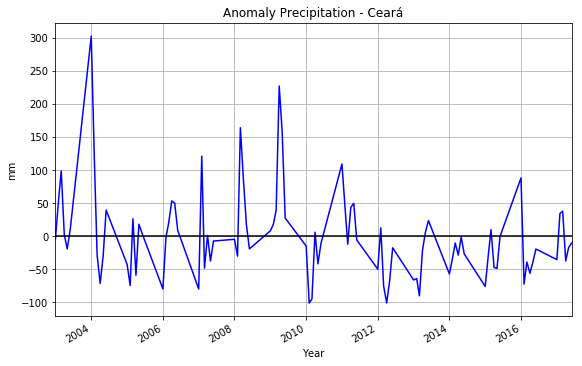

In [11]:
plota_coluna_do_dataframe(rainy_classified_df, 'Anomaly Precipitation - Ceará',COLUNA_ANOMALIA_DO_MES)

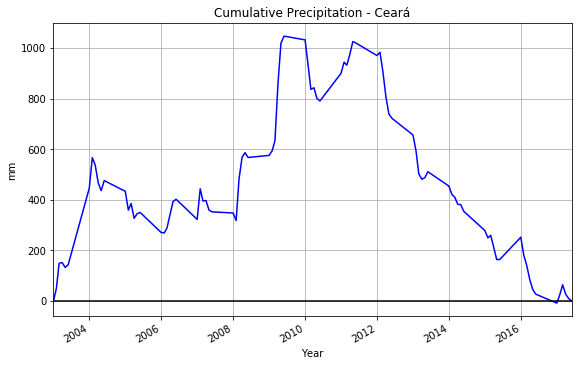

In [12]:
plota_coluna_do_dataframe(rainy_classified_df, 'Cumulative Precipitation - Ceará',COLUNA_ANOMALIA_ACUMULADA)